In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/Road-damage-classification.zip"

In [ ]:

datasets_dir =  "/content/sih_road_dataset"

In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 32
epochs = 40

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="training"

).prefetch(buffer_size=tf.data.AUTOTUNE)


test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size =  (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="validation"

)
class_names = test_dataset.class_names
test_data = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
# test_data = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
class_names


Found 2074 files belonging to 4 classes.
Using 1660 files for training.
Found 2074 files belonging to 4 classes.
Using 414 files for validation.


['good', 'poor', 'satisfactory', 'very_poor']

In [ ]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2)
], name="data_augmentation")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


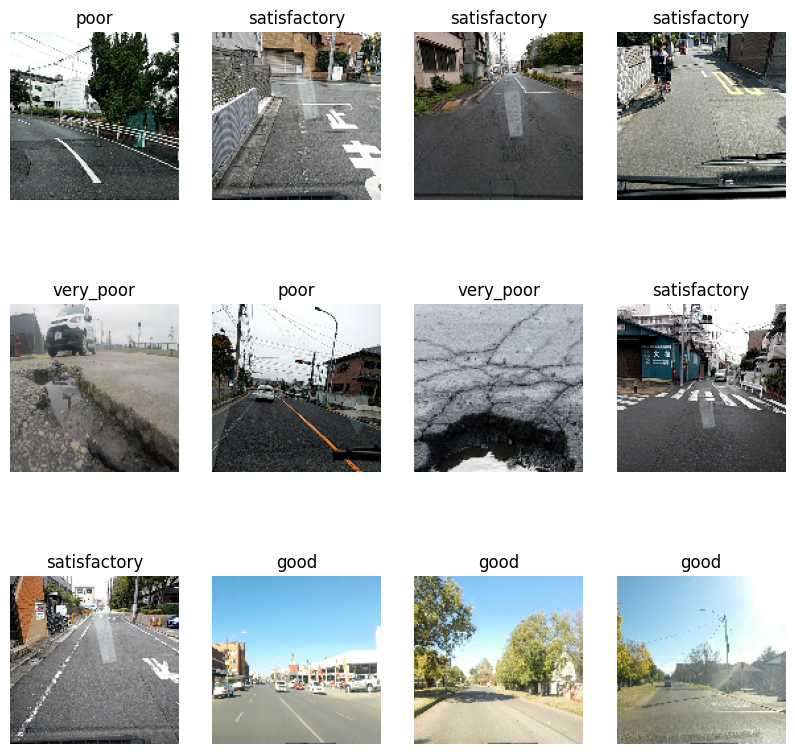

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10,10))

for image_batch,label_batch in train_data.take(1):
    for i in range(0,12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

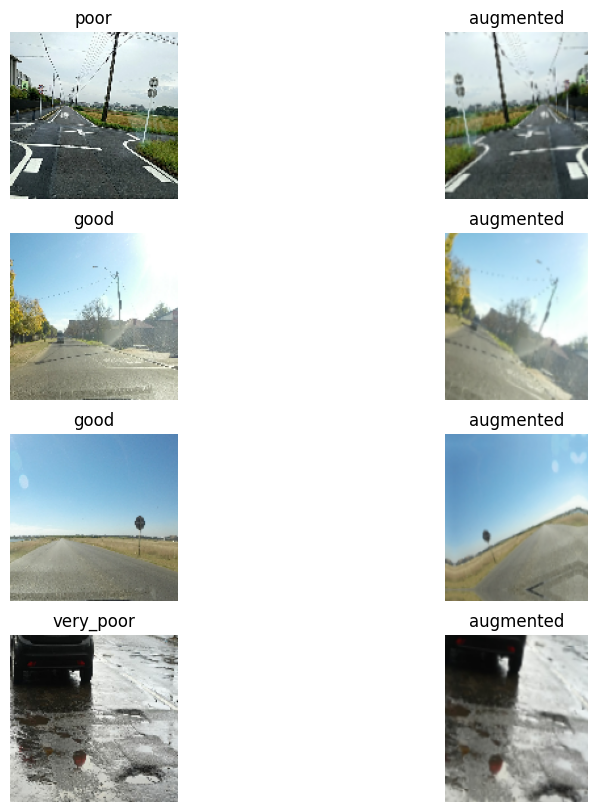

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        img = augmented_image_batch[i]
        img = np.array(img, dtype=np.int32)
        plt.imshow(img)
        plt.title(f"augmented")
        plt.axis("off")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pooling_layer             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 2,531,988 (9.66 MB)

 Non-trainable params: 1,522,707 (5.81 MB)

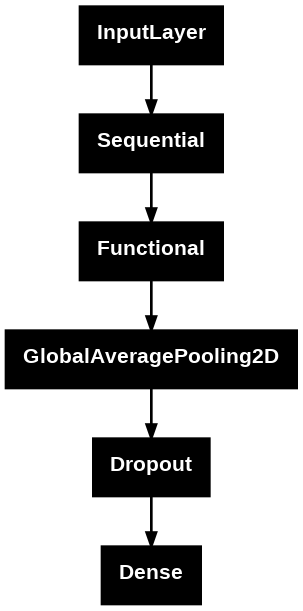

In [ ]:
import tensorflow as tf

# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True  # Enable fine-tuning

# Fine-tune only the last N layers
fine_tune_at = 50
for layer in base_model.layers[:-fine_tune_at]:
    layer.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout for regularization
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adjust the learning rate
    metrics=['accuracy']
)
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# Learning rate schedule callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)


model.summary()
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    dpi=96,

)

In [ ]:
# Train the model with the learning rate schedule
history = model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 432ms/step - accuracy: 0.4653 - loss: 1.2039 - val_accuracy: 0.8382 - val_loss: 0.6108 - learning_rate: 1.0000e-04
Epoch 2/40


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/40


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 351ms/step - accuracy: 0.8269 - loss: 0.5127 - val_accuracy: 0.8865 - val_loss: 0.3448 - learning_rate: 1.0000e-04
Epoch 4/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 342ms/step - accuracy: 0.8715 - loss: 0.3622 - val_accuracy: 0.9130 - val_loss: 0.2916 - learning_rate: 1.0000e-04
Epoch 6/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 357ms/step - accuracy: 0.8948 - loss: 0.3118 - val_accuracy: 0.9034 - val_loss: 0.3034 - learning_rate: 1.0000e-04
Epoch 8/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 336ms/step - accuracy: 0.9114 - loss: 0.2584 - val_accuracy: 0.8986 - val_loss: 0.2983 - learning_rate: 1.0000e-04
Epoch 10/40
52/52 ━━━━

In [ ]:
# Evaluate the model on both training and testing sets
model.evaluate(train_data), model.evaluate(test_data)

52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - accuracy: 0.9111 - loss: 0.3009
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.9150 - loss: 0.2710


([0.29836705327033997, 0.9114457964897156],
 [0.2915946841239929, 0.9130434989929199])

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # plt.figure(figsize=(12,6))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [ ]:
model.save('/content/my_model.keras')

In [ ]:
model.export('/content/my_model')

Saved artifact at '/content/my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135402881885008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402881888000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402881890464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402871374592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402871377056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402737044288: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135402341065024: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135402603170800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402341281008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402603382736: TensorSpec(shape=(), dtype=tf.resource, name=None

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmp5e02eo5l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135402737044288: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135402341065024: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135402603170800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402341281008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402603382736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402603393472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402736800464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402341282944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402341282240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402341280128: TensorSpec(shape=(), dtype=tf.resource, name=None)

In [ ]:
# Write the converted model to a file
with open('/content/model.tflite', 'wb') as f:
    f.write(tflite_model)
print("TFLite model saved successfully")

TFLite model saved successfully


In [ ]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))  # Match to the length of the loss array

    plt.figure(figsize=(12, 6))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()


In [ ]:
from sklearn.metrics import classification_report

# Evaluate the model on the test set
y_true = np.array([])
y_pred = np.array([])
for x, y in test_data:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

# Display classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
               precision    recall  f1-score   support

        good       0.99      0.91      0.95       151
        poor       0.78      0.84      0.81        74
satisfactory       0.88      0.94      0.91       112
   very_poor       0.97      0.95      0.96        77

    accuracy                           0.91       414
   macro avg       0.90      0.91      0.91       414
weighted avg       0.92      0.91      0.91       414

